In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

#set up
import torch, detectron2
print("detectron2:", detectron2.__version__)

from detectron2.utils.logger import setup_logger
setup_logger()

# import common libraries
import numpy as np
import os, json, cv2, random

# import detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from matplotlib import pyplot as plt

%matplotlib inline

/bin/bash: nvcc: command not found
torch:  2.2 ; cuda:  cu121
detectron2: 0.6
detectron2: 0.6


In [3]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import get_detection_dataset_dicts
from detectron2.data.datasets import  builtin_meta

In [4]:
Root_Dir = "/work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2"  ### Your directory to the trained/Valid folder

# Construct the paths relative to the base directory

#/Train_Input/GuardSeg6
train_annotations_path = os.path.join(Root_Dir, "Train_Input", "GuardSeg6", "train", "_annotations.coco.json")

train_images_dir = os.path.join(Root_Dir, "Train_Input", "GuardSeg6", "train")
print(train_annotations_path)
valid_annotations_path = os.path.join(Root_Dir, "Train_Input", "GuardSeg6", "valid", "_annotations.coco.json")
valid_images_dir = os.path.join(Root_Dir, "Train_Input", "GuardSeg6", "valid")

# Register COCO instances using the constructed paths
register_coco_instances("guard_train", {}, train_annotations_path, train_images_dir)
register_coco_instances("guard_valid", {}, valid_annotations_path, valid_images_dir)

/work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/Train_Input/GuardSeg6/train/_annotations.coco.json


In [5]:
dataset_dicts = get_detection_dataset_dicts(["guard_train"])
_dataset_metadata = MetadataCatalog.get("guard_train")
_dataset_metadata.thing_colors = [cc['color'] for cc in builtin_meta.COCO_CATEGORIES]
NUM_CLASSES = len(_dataset_metadata.thing_classes)
print(f"{NUM_CLASSES} Number of classes in the dataset")

WARNING [03/11 19:31:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/11 19:31:34 d2.data.datasets.coco]: Loaded 31 images in COCO format from /work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/Train_Input/GuardSeg6/train/_annotations.coco.json
[03/11 19:31:34 d2.data.build]: Removed 1 images with no usable annotations. 30 images left.
[03/11 19:31:34 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   GC-SC    | 0            |     GC     | 344          |     SC     | 689          |
|            |              |            |              |            |              |
|   total    | 1033         |            |              |            |              |
3 Number of classes in the dataset


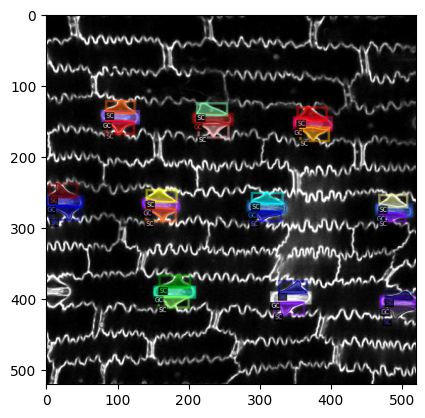

In [6]:
###check the dataset and annotation
for d in random.sample(dataset_dicts, 2):
    if '\\' in d['file_name']:
        d['file_name'] = d['file_name'].replace('\\','/')
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=_dataset_metadata)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])

In [9]:
os.getcwd()

'/work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2'

In [10]:
### Train the model
from detectron2.engine import DefaultTrainer
cfg = get_cfg()

cfg.MODEL.DEVICE='cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("guard_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2 #@param
cfg.DATALOADER.SAMPLER_TRAIN = "RepeatFactorTrainingSampler"
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from basic model frommodel zoo
cfg.SOLVER.IMS_PER_BATCH =  2 #@param
cfg.SOLVER.BASE_LR = 0.00025 #@param # pick a good LR
cfg.SOLVER.MAX_ITER = 2000 #@param    # 300 iterations seems good enough for 100 frames dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 #@param   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  #  (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[03/08 16:55:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

In [25]:
import tensorflow as tf
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [11]:
trainer.train()

[03/08 16:55:56 d2.engine.train_loop]: Starting training from iteration 0


/home/lliu4_umass_edu/.local/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/08 16:57:12 d2.utils.events]:  eta: 2:04:56  iter: 19  total_loss: 6.491  loss_cls: 1.593  loss_box_reg: 0.4274  loss_mask: 0.6921  loss_rpn_cls: 3.541  loss_rpn_loc: 0.2462    time: 3.7066  last_time: 3.3674  data_time: 0.0260  last_data_time: 0.0037   lr: 4.9953e-06  max_mem: 0M


2024-03-08 16:57:15.038945: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 16:57:16.592741: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 16:57:21.998967: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[03/08 16:58:44 d2.utils.events]:  eta: 2:01:34  iter: 39  total_loss: 3.852  loss_cls: 1.444  loss_box_reg: 0.6305  loss_mask: 0.6907  loss_rpn_cls: 0.8204  loss_rpn_loc: 0.1982    time: 3.6468  last_time: 3.7032  data_time: 0.0076  last_data_time: 0.0037   lr: 9.9902e-06  max_mem: 0M
[03/08 16:59:54 d2.utils.events]:  eta: 1:59:41  iter: 59  total_loss: 2.995  loss_cls: 1.259  loss_box_reg: 0.6899  loss_mask: 0.6881  loss_rpn_cls: 0.1691  loss_rpn_loc: 0.1855    time: 3.5964  last_time: 4.0704  data_time: 0.0057  last_data_time: 0.0046   lr: 1.4985e-05  max_mem: 0M
[03/08 17:01:01 d2.utils.events]:  eta: 1:56:42  iter: 79  total_loss: 2.755  loss_cls: 1.077  loss_box_reg: 0.7293  loss_mask: 0.6836  loss_rpn_cls: 0.1061  loss_rpn_loc: 0.1807    time: 3.5343  last_time: 3.6241  data_time: 0.0047  last_data_time: 0.0039   lr: 1.998e-05  max_mem: 0M
[03/08 17:02:09 d2.utils.events]:  eta: 1:54:51  iter: 99  total_loss: 2.626  loss_cls: 0.8834  loss_box_reg: 0.7625  loss_mask: 0.6783  los

In [12]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. 
# We simply update the weights with the newly trained ones to perform inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
# set a custom testing threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9   #@param {type: "slider", min:0.0, max:1.0, step: 0.01}
predictor = DefaultPredictor(cfg)
from detectron2.utils.visualizer import ColorMode

[03/08 18:53:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [15]:
## Save Model Configuration to YAML file
config_yaml_path = os.path.join(cfg.OUTPUT_DIR, "GuardSeg_model.yaml")

with open(config_yaml_path, "w") as f:
    f.write(cfg.dump())
        
# Save only the model weights
output_dir = cfg.OUTPUT_DIR
model_weights_path = os.path.join(output_dir, "model_final.pth")
torch.save(trainer.model.state_dict(), model_weights_path)

In [9]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. 
# We simply update the weights with the newly trained ones to perform inference:

cfg.MODEL.WEIGHTS = "/work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/output/model_final.pth"  # path to the model we just trained
# set a custom testing threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6 #@param {type: "slider", min:0.0, max:1.0, step: 0.01}
predictor = DefaultPredictor(cfg)


[03/06 02:59:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/output/model_final.pth ...


WARNING [03/08 18:54:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/08 18:54:23 d2.data.datasets.coco]: Loaded 9 images in COCO format from /work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/Train_Input/GuardSeg6/valid/_annotations.coco.json
[03/08 18:54:23 d2.data.build]: Removed 0 images with no usable annotations. 9 images left.


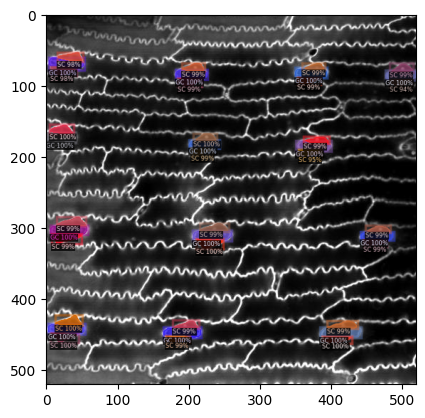

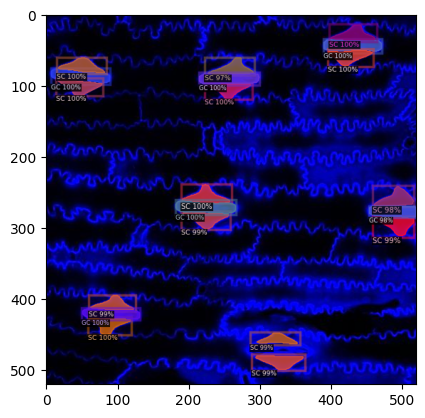

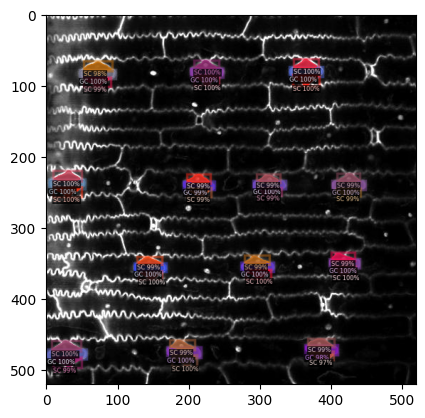

In [16]:
dataset_dicts = get_detection_dataset_dicts(["guard_valid"])
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=_dataset_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.SEGMENTATION   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()
        

In [12]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("guard_valid", cfg, False, output_dir="eval_output/")

val_loader = build_detection_test_loader(cfg, "guard_valid")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[03/01 22:37:45 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [03/01 22:37:45 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [03/01 22:37:45 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/01 22:37:45 d2.data.datasets.coco]: Loaded 9 images in COCO format from /work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/Train_Input/GuardSeg6/valid/_annotations.coco.json
[03/01 22:37:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/01 22:37:45 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/01 22:37:45 d2.data.common]: Serializing 9 elements to byte tensors and conc